# Buffered pH Dynamics

Using checked-in code. Ref: Glaser _et al_ (2014) https://doi.org/10.1021/ed400808c

In [1]:
import projectpath

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
import scipy.optimize

from knowledge import kb
from model.core import KbEntry, Molecule
from sim.ph_dynamics import PROTON, AcidSet, PhBuffer

jax.config.update('jax_enable_x64', True)
KB = kb.configure_kb()

## From Glaser _et al_, malic acid equilibrium in water

In [2]:
malate = AcidSet.for_acid('L-mal', 0, [3.46, 5.10])
buffer = PhBuffer([malate])
%time equilibrium = buffer.equilibrium(concs={('L-mal(+0)', 0): 0.1})
print(pd.Series(equilibrium))
print(f'Final pH: {-np.log10(equilibrium[PROTON]):.2f}')

CPU times: user 206 ms, sys: 16.7 ms, total: 222 ms
Wall time: 217 ms
H           1    5.725546e-03
H2O         0    1.000000e+00
OH         -1    1.746558e-12
L-mal(+0)   0    9.428237e-02
L-mal(-1)  -1    5.709704e-03
L-mal(-2)  -2    7.921303e-06
dtype: float64
Final pH: 2.24


### Titrate the mixture to the pKa of the less acidic site

In [3]:
%time equilibrium = buffer.titrate(concs={('L-mal(+0)', 0): 0.1}, pH=malate.p_kas[-1])
print(pd.Series(equilibrium))
print(f'Final pH: {-np.log10(equilibrium[PROTON]):.2f}')

CPU times: user 325 ms, sys: 5.15 ms, total: 330 ms
Wall time: 325 ms
H           1    7.943282e-06
H2O         0    1.000000e+00
OH         -1    1.258925e-09
L-mal(+0)   0    1.132462e-03
L-mal(-1)  -1    4.943377e-02
L-mal(-2)  -2    4.943377e-02
dtype: float64
Final pH: 5.10


## Reproduce Glaser _et al_ Figure 4: pH as a function of:
- [L-mal(+0)]
- [L-mal(-1)]
- [L-mal(-1)] + 0.01 M [L-mal(+0)]

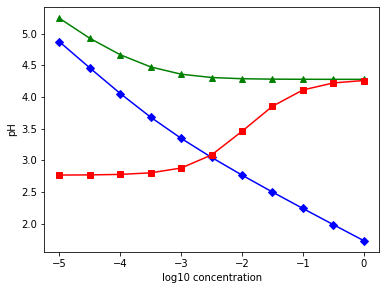

CPU times: user 4.84 s, sys: 171 ms, total: 5.02 s
Wall time: 4.81 s


In [4]:
%%time
conc_range = np.power(10, np.arange(-5, 0.5, 0.5))

def equilibrium_pH(buffer, concs):
    return -np.log10(buffer.equilibrium(concs)[PROTON])

dilute_malic_acid_pH = [equilibrium_pH(buffer, {malate.species[0]: conc}) for conc in conc_range]
dilute_malate_pH = [equilibrium_pH(buffer, {malate.species[1]: conc}) for conc in conc_range]
malate_buffer_pH = [equilibrium_pH(buffer, {malate.species[0]: 0.01, malate.species[1]: conc}) for conc in conc_range]

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax.plot(np.log10(conc_range), dilute_malate_pH, label='malate', marker='^', color='g')
ax.plot(np.log10(conc_range), dilute_malic_acid_pH, label='malic acid', marker='D', color='b')
ax.plot(np.log10(conc_range), malate_buffer_pH, label='malate/malic acid buffer', marker='s', color='r')
ax.set_ylabel('pH')
ax.set_xlabel('log10 concentration')
plt.show()

## Protonation as a function of pH

CPU times: user 10.2 s, sys: 23.5 ms, total: 10.2 s
Wall time: 10.2 s


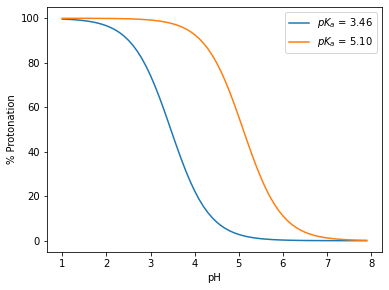

In [5]:
pH_range = np.arange(1.0, 8.0, 0.1)

%time species_by_pH = [buffer.titrate(concs={('L-mal(+0)', 0): 0.1}, pH=pH) for pH in pH_range]
df = pd.DataFrame(species_by_pH, index=pH_range)

protonation = [
    df[malate.species[0]] / (df[malate.species[0]] + df[malate.species[1]]),
    df[malate.species[1]] / (df[malate.species[1]] + df[malate.species[2]]),
]

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax.plot(pH_range, protonation[0] * 100, label=f'$pK_a$ = {malate.p_kas[0]:.2f}')
ax.plot(pH_range, protonation[1] * 100, label=f'$pK_a$ = {malate.p_kas[1]:.2f}')
ax.set_xlabel('pH')
ax.set_ylabel('% Protonation')
ax.legend()
plt.show()

## Protonated species dynamics over time

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 168 ms


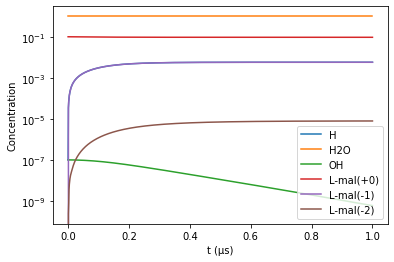

Final pH: 2.24


In [6]:
%time sim = buffer.simulate(concs={('L-mal(+0)', 0): 0.1}, pH=7.0, end=1e-6, step=1e-9)
pd.DataFrame(
    sim.y.T,
    index=sim.t * 1e6,
    columns=[mol[0] for mol in buffer.mols],
).plot(
    xlabel='t (μs)',
    ylabel='Concentration',
    logy=True,
)
plt.show()
print(f'Final pH: {-np.log10(sim.y[0][-1]):.2f}')